In [3]:
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.models.efficientnet import MBConvConfig, FusedMBConvConfig

sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab2-group6/code/modeling")
from preprocessing import to_NCHW, pad_to_384x384, standardize_images
from autoencoder import EfficientNetEncoder, EfficientNetDecoder, AutoencoderConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True
use_amp = True

In [2]:
# Load and preprocess data
data = np.load("/jet/home/azhang19/stat 214/stat-214-lab2-group6/data/array_data.npz")
unlabeled_images, unlabeled_masks, labeled_images, labeled_masks, labels = data["unlabeled_images"], data["unlabeled_masks"], data["labeled_images"], data["labeled_masks"], data["labels"]

unlabeled_images = pad_to_384x384(to_NCHW(unlabeled_images))
unlabeled_masks = pad_to_384x384(unlabeled_masks)

labeled_images = pad_to_384x384(to_NCHW(labeled_images))
labeled_masks = pad_to_384x384(labeled_masks)
labels = pad_to_384x384(labels)

# Convert to tensors and move to GPU
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32).to(device)  # [161, 8, 384, 384]
unlabeled_masks = torch.tensor(unlabeled_masks, dtype=torch.bool).to(device)    # [161, 384, 384]

labeled_images = torch.tensor(labeled_images, dtype=torch.float32).to(device)      # [3, 8, 384, 384]
labeled_masks = torch.tensor(labeled_masks, dtype=torch.bool).to(device)        # [3, 384, 384]
labels = torch.tensor(labels, dtype=torch.long).to(device)                      # [3, 384, 384]


# Standardize images
unlabeled_images, std_channel, mean_channel = standardize_images(unlabeled_images, unlabeled_masks)
labeled_images, _, _ = standardize_images(labeled_images, labeled_masks, std_channel, mean_channel)

In [4]:
config = AutoencoderConfig(num_layers_block=[1, 1, 1], augmentation_flip=True, augmentation_rotate=True)

In [4]:
encoder_config = [
    FusedMBConvConfig(1, 3, 1, 16, 16, config.num_layers_block[0]),  # 384x384x8 -> 384x384x16
    FusedMBConvConfig(4, 3, 2, 16, 32, config.num_layers_block[1]),  # 384x384x16 -> 192x192x32
    MBConvConfig(4, 3, 2, 32, 64, config.num_layers_block[2]),       # 192x192x32 -> 96x96x64
]

# Build encoder and decoder
encoder = EfficientNetEncoder(
    inverted_residual_setting=encoder_config,
    dropout=0.1,
    input_channels=8,
    last_channel=64,
)

decoder = EfficientNetDecoder()

autoencoder = nn.Sequential(encoder, decoder).train().to(device)
#compiled_autoencoder = torch.compile(autoencoder)

In [ ]:
num_epochs = 20000  # Small dataset, so 100 epochs is reasonable
initial_lr = 1e-3  # Moderate starting LR for AdamW
weight_decay = 1e-2  # Regularization for small dataset

# Optimizer and scheduler
optimizer = optim.AdamW(autoencoder.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)  # Decay to near-zero
scaler = torch.amp.GradScaler(device, enabled=use_amp)

losses = np.zeros(num_epochs)

In [6]:
@torch.compile
def trainer(images, masks, model, optimizer, scheduler, scaler, loss_fn):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    with torch.amp.autocast(device, enabled=use_amp):
        reconstructions = model(images)
        loss = loss_fn(images, masks, reconstructions)

    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()

    scheduler.step()

    return loss

In [7]:
for epoch in range(num_epochs):
    t = time.perf_counter()
    loss = trainer(unlabeled_images, unlabeled_masks, autoencoder, optimizer, scheduler, scaler, masked_mse).item()
    losses[epoch] = loss
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss:.4f} - Time: {time.perf_counter() - t:.2f}s")

W0306 02:16:30.807000 98430 site-packages/torch/_logging/_internal.py:1089] [10/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored
('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].

Epoch 1/10000 - Loss: 2.1900 - Time: 12.58s


('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].param_groups[0]['params'][17].grad", "L['self'].param_groups[0]['params'][18].grad", "L['self'].param_groups[0]['params'][19].grad", "L['self'].param_groups[0]['params

Epoch 2/10000 - Loss: 1.8817 - Time: 2.43s


('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].param_groups[0]['params'][17].grad", "L['self'].param_groups[0]['params'][18].grad", "L['self'].param_groups[0]['params'][19].grad", "L['self'].param_groups[0]['params

Epoch 3/10000 - Loss: 1.6800 - Time: 1.69s


('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].param_groups[0]['params'][17].grad", "L['self'].param_groups[0]['params'][18].grad", "L['self'].param_groups[0]['params'][19].grad", "L['self'].param_groups[0]['params

Epoch 4/10000 - Loss: 1.4930 - Time: 1.47s


('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].param_groups[0]['params'][17].grad", "L['self'].param_groups[0]['params'][18].grad", "L['self'].param_groups[0]['params'][19].grad", "L['self'].param_groups[0]['params

Epoch 5/10000 - Loss: 1.3311 - Time: 1.46s


('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].param_groups[0]['params'][17].grad", "L['self'].param_groups[0]['params'][18].grad", "L['self'].param_groups[0]['params'][19].grad", "L['self'].param_groups[0]['params

Epoch 6/10000 - Loss: 1.1923 - Time: 1.74s


('Grad tensors ["L['self'].param_groups[0]['params'][0].grad", "L['self'].param_groups[0]['params'][1].grad", "L['self'].param_groups[0]['params'][2].grad", "L['self'].param_groups[0]['params'][3].grad", "L['self'].param_groups[0]['params'][4].grad", "L['self'].param_groups[0]['params'][5].grad", "L['self'].param_groups[0]['params'][6].grad", "L['self'].param_groups[0]['params'][7].grad", "L['self'].param_groups[0]['params'][8].grad", "L['self'].param_groups[0]['params'][9].grad", "L['self'].param_groups[0]['params'][10].grad", "L['self'].param_groups[0]['params'][11].grad", "L['self'].param_groups[0]['params'][12].grad", "L['self'].param_groups[0]['params'][13].grad", "L['self'].param_groups[0]['params'][14].grad", "L['self'].param_groups[0]['params'][15].grad", "L['self'].param_groups[0]['params'][16].grad", "L['self'].param_groups[0]['params'][17].grad", "L['self'].param_groups[0]['params'][18].grad", "L['self'].param_groups[0]['params'][19].grad", "L['self'].param_groups[0]['params

Epoch 7/10000 - Loss: 1.0703 - Time: 1.46s


W0306 02:16:44.276000 98430 site-packages/torch/_dynamo/convert_frame.py:906] [11/8] torch._dynamo hit config.cache_size_limit (8)
W0306 02:16:44.276000 98430 site-packages/torch/_dynamo/convert_frame.py:906] [11/8]    function: 'step' (/jet/home/azhang19/.conda/envs/env_214/lib/python3.13/site-packages/torch/optim/adamw.py:207)
W0306 02:16:44.276000 98430 site-packages/torch/_dynamo/convert_frame.py:906] [11/8]    last reason: 11/0: L['self'].param_groups[0]['lr'] == 0.001                    
W0306 02:16:44.276000 98430 site-packages/torch/_dynamo/convert_frame.py:906] [11/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0306 02:16:44.276000 98430 site-packages/torch/_dynamo/convert_frame.py:906] [11/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Epoch 8/10000 - Loss: 0.9602 - Time: 1.46s
Epoch 9/10000 - Loss: 0.8596 - Time: 0.13s
Epoch 10/10000 - Loss: 0.7702 - Time: 0.11s
Epoch 11/10000 - Loss: 0.6911 - Time: 0.11s
Epoch 12/10000 - Loss: 0.6223 - Time: 0.11s
Epoch 13/10000 - Loss: 0.5658 - Time: 0.11s
Epoch 14/10000 - Loss: 0.5224 - Time: 0.11s
Epoch 15/10000 - Loss: 0.4884 - Time: 0.11s
Epoch 16/10000 - Loss: 0.4603 - Time: 0.11s
Epoch 17/10000 - Loss: 0.4372 - Time: 0.11s
Epoch 18/10000 - Loss: 0.4181 - Time: 0.11s
Epoch 19/10000 - Loss: 0.4024 - Time: 0.11s
Epoch 20/10000 - Loss: 0.3891 - Time: 0.11s
Epoch 21/10000 - Loss: 0.3775 - Time: 0.11s
Epoch 22/10000 - Loss: 0.3671 - Time: 0.11s
Epoch 23/10000 - Loss: 0.3577 - Time: 0.11s
Epoch 24/10000 - Loss: 0.3488 - Time: 0.11s
Epoch 25/10000 - Loss: 0.3406 - Time: 0.11s
Epoch 26/10000 - Loss: 0.3328 - Time: 0.11s
Epoch 27/10000 - Loss: 0.3257 - Time: 0.11s
Epoch 28/10000 - Loss: 0.3190 - Time: 0.11s
Epoch 29/10000 - Loss: 0.3126 - Time: 0.11s
Epoch 30/10000 - Loss: 0.3062 - Ti

In [114]:
# Deterministic Convlutional from now on
torch.use_deterministic_algorithms(True)

encoder = encoder.eval()
with torch.inference_mode():
    feature = encoder(labeled_images)
feature = feature.clone()

In [170]:
classifier = nn.ConvTranspose2d(
            in_channels=64,      # Input channels from latent
            out_channels=1,      # Output channel for binary classification
            kernel_size=4,       # Chosen for exact size
            stride=4,            # Upsample 96 -> 384 (4x)
            padding=0,           # No padding needed
            output_padding=0     # No adjustment needed
            ).to(device)

In [171]:
classifier_optimizer = optim.AdamW(classifier.parameters(), lr=1e-2, weight_decay=1e-2)
classifier_loss_fn = nn.BCEWithLogitsLoss()

In [172]:
def masked_bce_loss_acc(logits, labels):
    logits = logits.flatten()
    labels = labels.flatten()
    mask = (labels != 0)

    pred = logits[mask]
    target = (labels[mask] + 1) // 2  # Convert from -1/1 to 0/1

    loss = nn.functional.binary_cross_entropy_with_logits(pred, target.float())
    acc = ((pred > 0) == target).float().mean()

    return loss, acc

In [173]:
train, val, test = feature.unsqueeze(1)
#train, val, test = val, train, test
train_labels, val_labels, test_labels = labels.unsqueeze(1)
#train_labels, val_labels, test_labels = val_labels, train_labels, test_labels

In [ ]:
record = np.zeros((10000, 4))
for epoch in range(10000):
    classifier_optimizer.zero_grad(set_to_none=True)
    pred = classifier(train)
    loss, acc = masked_bce_loss_acc(pred, train_labels)
    print(f"Epoch {epoch + 1} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")
    loss.backward()
    classifier_optimizer.step()
    with torch.inference_mode():
        val_pred = classifier(val)
        val_loss, val_acc = masked_bce_loss_acc(val_pred, val_labels)
        print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
        print()
    record[epoch] = [loss.item(), acc.item(), val_loss.item(), val_acc.item()]

Text(0, 0.5, 'Accuracy')

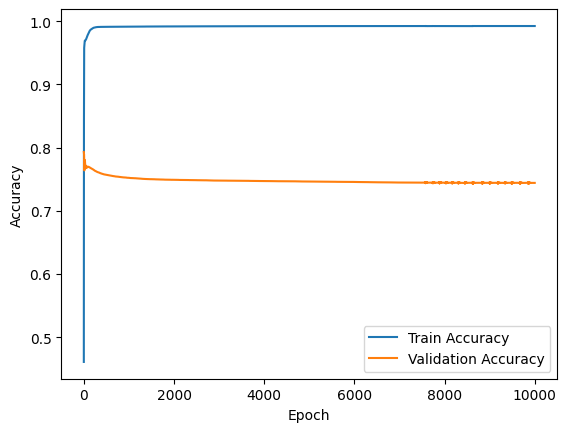

In [210]:
plt.plot(record[:, 1], label="Train Accuracy")
plt.plot(record[:, 3], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [208]:
baseline = nn.Conv2d(
            in_channels=8,    # Input channels
            out_channels=1,   # Output channel for binary classification
            kernel_size=4,    # 4x4 kernel
            stride=1,         # No downsampling
            padding="same"    # Padding to maintain size
            ).to(device)

In [209]:
baseline_train, baseline_val, baseline_test = labeled_images.unsqueeze(1)
#baseline_val, baseline_train, baseline_test = baseline_train, baseline_val, baseline_test
baseline_train_labels, baseline_val_labels, baseline_test_labels = labels.unsqueeze(1)
#baseline_val_labels, baseline_train_labels, baseline_test_labels = baseline_train_labels, baseline_val_labels, baseline_test_labels

baseline_optimizer = optim.AdamW(baseline.parameters(), lr=1e-2, weight_decay=1e-2)
record = np.zeros((10000, 4))
for epoch in range(10000):
    baseline_optimizer.zero_grad(set_to_none=True)
    pred = baseline(baseline_train)
    loss, acc = masked_bce_loss_acc(pred, baseline_train_labels)
    print(f"Epoch {epoch + 1} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")
    loss.backward()
    baseline_optimizer.step()
    with torch.inference_mode():
        val_pred = baseline(baseline_val)
        val_loss, val_acc = masked_bce_loss_acc(val_pred, baseline_val_labels)
        print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
        print()
    record[epoch] = [loss.item(), acc.item(), val_loss.item(), val_acc.item()]

Epoch 1 - Loss: 0.7388 - Accuracy: 0.4609
Validation Loss: 0.5558 - Validation Accuracy: 0.7931

Epoch 2 - Loss: 0.5201 - Accuracy: 0.8334
Validation Loss: 0.4881 - Validation Accuracy: 0.7918

Epoch 3 - Loss: 0.4146 - Accuracy: 0.8211
Validation Loss: 0.4977 - Validation Accuracy: 0.7909

Epoch 4 - Loss: 0.3551 - Accuracy: 0.8427
Validation Loss: 0.5321 - Validation Accuracy: 0.7902

Epoch 5 - Loss: 0.3107 - Accuracy: 0.8810
Validation Loss: 0.5719 - Validation Accuracy: 0.7900

Epoch 6 - Loss: 0.2728 - Accuracy: 0.9153
Validation Loss: 0.6113 - Validation Accuracy: 0.7899

Epoch 7 - Loss: 0.2409 - Accuracy: 0.9384
Validation Loss: 0.6491 - Validation Accuracy: 0.7884

Epoch 8 - Loss: 0.2156 - Accuracy: 0.9516
Validation Loss: 0.6852 - Validation Accuracy: 0.7829

Epoch 9 - Loss: 0.1968 - Accuracy: 0.9578
Validation Loss: 0.7186 - Validation Accuracy: 0.7761

Epoch 10 - Loss: 0.1833 - Accuracy: 0.9602
Validation Loss: 0.7481 - Validation Accuracy: 0.7700

Epoch 11 - Loss: 0.1735 - Acc

Epoch 174 - Loss: 0.0559 - Accuracy: 0.9877
Validation Loss: 1.1043 - Validation Accuracy: 0.7669

Epoch 175 - Loss: 0.0558 - Accuracy: 0.9877
Validation Loss: 1.1054 - Validation Accuracy: 0.7669

Epoch 176 - Loss: 0.0556 - Accuracy: 0.9878
Validation Loss: 1.1065 - Validation Accuracy: 0.7668

Epoch 177 - Loss: 0.0555 - Accuracy: 0.9878
Validation Loss: 1.1076 - Validation Accuracy: 0.7668

Epoch 178 - Loss: 0.0553 - Accuracy: 0.9879
Validation Loss: 1.1087 - Validation Accuracy: 0.7667

Epoch 179 - Loss: 0.0552 - Accuracy: 0.9880
Validation Loss: 1.1099 - Validation Accuracy: 0.7667

Epoch 180 - Loss: 0.0550 - Accuracy: 0.9881
Validation Loss: 1.1110 - Validation Accuracy: 0.7666

Epoch 181 - Loss: 0.0549 - Accuracy: 0.9881
Validation Loss: 1.1121 - Validation Accuracy: 0.7666

Epoch 182 - Loss: 0.0547 - Accuracy: 0.9882
Validation Loss: 1.1132 - Validation Accuracy: 0.7665

Epoch 183 - Loss: 0.0546 - Accuracy: 0.9882
Validation Loss: 1.1143 - Validation Accuracy: 0.7665

Epoch 184 